In [3]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [4]:
import zipfile
zip_ref = zipfile.ZipFile("/content/drive/My Drive/MLDATA/labeval1data.zip", 'r')
zip_ref.extractall("/tmp")

In [5]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import glob
import matplotlib.pyplot as plt
import warnings
%matplotlib inline

In [6]:
!ls /tmp

dap_multiplexer.92cceddaacc6.root.log.INFO.20220318-110944.55
dap_multiplexer.INFO
debugger_2fvj2vposm
directoryprefetcher_binary.92cceddaacc6.root.log.INFO.20220318-112932.293
directoryprefetcher_binary.INFO
drivefs_ipc.0
drivefs_ipc.0_shell
initgoogle_syslog_dir.0
labeval1data
pyright-106-lNTl47vtPXBB
pyright-106-vXal1ptQ7lli
pyright-123-m3Tiua9bFVRr
pyright-123-t4JTuaRSyQ1X
pyright-138-85TL23ewqGGj
pyright-138-BDXFv8R00hFQ
python-languageserver-cancellation


In [11]:
train_path = '/tmp/labeval1data/train'
valid_path = '/tmp/labeval1data/valid'
test_path = '/tmp/labeval1data/test'

shapes_list = ["Octagon" , "Triangle" , "Nonagon" , "Star" , "Hexagon" , "Square" , "Heptagon" , "Pentagon" , "Circle"]

In [12]:

# converting data into batches
# target size = height and width of the images we want images to be resized to [for reduced complexity]
# classes = all output classes
train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=train_path, target_size=(224,224), classes=shapes_list, batch_size=25)
valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=valid_path, target_size=(224,224), classes=shapes_list, batch_size=25)
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=test_path, target_size=(224,224), classes=shapes_list, batch_size=25, shuffle=False)

Found 215981 images belonging to 9 classes.
Found 18000 images belonging to 9 classes.
Found 18000 images belonging to 9 classes.


In [13]:
# get first batch images and labels
imgs, labels = next(train_batches)

In [14]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 25, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

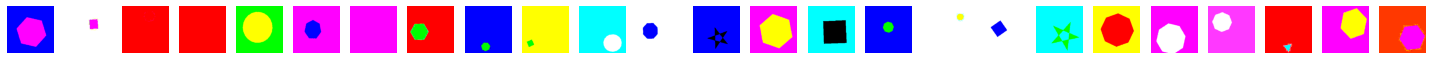

[[0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0.]]


In [15]:
plotImages(imgs)
print(labels)

In [16]:
# implementing model
model = Sequential([
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding = 'same', input_shape=(224,224,3)),  # 3 is regarding the color channels like 3 in RGB
    
    # We then add a max pooling layer to pool and reduce the dimensionality of the data.
    MaxPool2D(pool_size=(2, 2), strides=2),
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding = 'same'),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Flatten(),
    Dense(units=len(shapes_list), activation='softmax')
])

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 200704)            0         
                                                                 
 dense (Dense)               (None, 9)                 1

In [18]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [19]:
history = model.fit(x=train_batches,
    steps_per_epoch=len(train_batches),
    validation_data=valid_batches,
    validation_steps=len(valid_batches),
    epochs=10,
    verbose=1
)

Epoch 1/10
8640/8640 [==============================] - 1149s 132ms/step - loss: 2.6699 - accuracy: 0.1886 - val_loss: 2.0038 - val_accuracy: 0.2213
Epoch 2/10
8640/8640 [==============================] - 1124s 130ms/step - loss: 1.8741 - accuracy: 0.2907 - val_loss: 2.0107 - val_accuracy: 0.2380
Epoch 3/10
8640/8640 [==============================] - 1105s 128ms/step - loss: 1.5429 - accuracy: 0.4329 - val_loss: 2.1655 - val_accuracy: 0.2359
Epoch 4/10
8640/8640 [==============================] - 1108s 128ms/step - loss: 1.2031 - accuracy: 0.5689 - val_loss: 2.5361 - val_accuracy: 0.2349
Epoch 5/10
8640/8640 [==============================] - 1121s 130ms/step - loss: 0.9371 - accuracy: 0.6689 - val_loss: 3.0228 - val_accuracy: 0.2293
Epoch 6/10
8640/8640 [==============================] - 1132s 131ms/step - loss: 0.7386 - accuracy: 0.7433 - val_loss: 3.5708 - val_accuracy: 0.2339
Epoch 7/10
8640/8640 [==============================] - 1109s 128ms/step - loss: 0.5899 - accuracy: 0.7966

In [20]:
import pickle

In [21]:
encoded = pickle.dumps(history)

INFO:tensorflow:Assets written to: ram://c2f44adf-f451-417d-9a5f-d90647a3bc04/assets


In [23]:
with open("/content/drive/My Drive/MLDATA/model_history.bin" , "wb") as file:
  file.write(encoded)

In [24]:
# saving the model
model.save('/content/drive/My Drive/MLDATA/saved_model.h5')